# RES Forecasting - Data Preprocessing

The Greek RES dataset combines information from different sources. It contains geolocation, weather and RES energy production data of the top contributors of wind and solar energy that contribute the 20% of the RES power in the Greek energy grid. The weather data were collected from a weather forecast API and represent the last generated forecast for each installation.

The data were collected from the following sources:

* RES energy production from [ENTSO-E](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show)
* Weather data captured using the [Stormglass API](https://docs.stormglass.io/#/weather?id=point-request)
* Wind turbine and PV installations geolocation data, for the locations that aquired operation licence as found in [Regulatory Authority for Energy (RAE)](https://geo.rae.gr/)

More information regarding energy licencing http://www.opengov.gr/minenv/?p=1031

In [1]:
from imports import *

data_eval = Evaluation()

## 1. Data Presentation
### 1.1 Data exploration 
#### 1.1.1 Data Loading 

Loading the data combined from the different data sources. The wind energy dataset contains the weather variable from the top wind energy contributors and the agreggated wind energy production from 2017 to 2020.

In [2]:
# Load solar data
solar_energy_path = os.path.join('resources', 'raw_data', 'solar_energy_data.csv')
solar_energy_df = pd.read_csv(solar_energy_path, parse_dates=['time'], date_parser=lambda col: pd.to_datetime(col, utc=True),)
solar_energy_df.loc[:, 'time'] = solar_energy_df.time.dt.tz_convert('CET')

solar_energy_df.sort_values(['id1', 'time'], inplace=True)
solar_energy_df.set_index('id1', inplace=True)
solar_energy_df.head()

,representative_lat,representative_lon,airTemperature,cloudCover,gust,humidity,precipitation,pressure,visibility,windDirection,windSpeed,time,energy_type,Solar energy (MW)
id1,,,,,,,,,,,,,,
11381,37.937648,23.946727,5.54,99.00,6.60,82.90,1.37,1025.07,19.743333,320.93,5.27,2017-01-01 01:00:00+01:00,solar,0.0
11381,37.937648,23.946727,5.53,98.17,6.13,83.37,1.22,1025.06,19.843333,323.93,4.86,2017-01-01 02:00:00+01:00,solar,0.0
11381,37.937648,23.946727,5.51,97.33,5.67,83.83,1.08,1025.05,19.333333,326.94,4.44,2017-01-01 03:00:00+01:00,solar,0.0
11381,37.937648,23.946727,5.50,96.50,5.20,84.30,0.93,1025.04,18.820000,329.94,4.03,2017-01-01 04:00:00+01:00,solar,0.0
11381,37.937648,23.946727,5.60,95.67,5.27,84.20,0.78,1025.07,18.310000,332.31,4.17,2017-01-01 05:00:00+01:00,solar,0.0


In [3]:
# Load Data wind data
wind_energy_path = os.path.join('resources', 'raw_data', 'wind_energy_data.csv')
wind_energy_df = pd.read_csv(wind_energy_path, parse_dates=['time'], date_parser=lambda col: pd.to_datetime(col, utc=True),)
wind_energy_df.loc[:, 'time'] = wind_energy_df.time.dt.tz_convert('CET')

wind_energy_df.sort_values(['id1', 'time'], inplace=True)
wind_energy_df.set_index('id1', inplace=True)
wind_energy_df.head()

,representative_lat,representative_lon,airTemperature,cloudCover,gust,humidity,precipitation,pressure,visibility,windDirection,windSpeed,time,energy_type,Wind energy (MW)
id1,,,,,,,,,,,,,,
32947,38.774952,20.993431,4.22,79.00,3.50,63.10,0.0,1026.40,24.010000,82.11,3.06,2017-01-01 01:00:00+01:00,wind,381.0
32947,38.774952,20.993431,4.20,65.83,3.17,63.03,0.0,1026.18,24.110000,80.21,2.75,2017-01-01 02:00:00+01:00,wind,391.0
32947,38.774952,20.993431,4.17,52.67,2.83,62.97,0.0,1025.97,23.670000,78.32,2.44,2017-01-01 03:00:00+01:00,wind,355.0
32947,38.774952,20.993431,4.15,39.50,2.50,62.90,0.0,1025.76,23.233333,76.42,2.13,2017-01-01 04:00:00+01:00,wind,360.0
32947,38.774952,20.993431,4.21,26.33,2.40,62.80,0.0,1025.77,22.793333,82.94,2.09,2017-01-01 05:00:00+01:00,wind,330.0


In [4]:
config = json.loads(open('config.json', 'r').read())
weather_features = [var for var in config['weather_variables'] if var in wind_energy_df.columns]

In [5]:
# Assert data integrity
for col in wind_energy_df.columns:
   assert(len(wind_energy_df[col].dropna()) == len(wind_energy_df.index))
   
for col in solar_energy_df.columns:
   assert(len(solar_energy_df[col].dropna()) == len(solar_energy_df.index))


#### 1.1.2 Top Greek RES Contributors Map

We focus on the top RES energy producers that contribute the 20% of the total wind and solar energy generation. We present all the installations and highlight the highest contributors

In [6]:
# Loading map config
with open(os.path.join('resources', 'map_config', 'res_map_config.json'), 'r') as res_map_config:
    res_map_config = json.loads(res_map_config.read())

In [7]:
# from keplergl import KeplerGl

# res_map = KeplerGl(height=700, width=400)
# res_map.add_data(wind_energy_df.append(solar_energy_df), 'Top Greek RES Parks')
# res_map.config = res_map_config
# res_map

In [8]:
# # Saving map style
# with open('map_config/res_map_config.json', 'w') as res_map_config:
#     json.dump(res_map.config, res_map_config)

#### 1.1.2 Data combination

For each energy type we aggregate the weather forecasts from the different locations to form a combined dataset 

In [9]:
agg_wind_energy_df = wind_energy_df.reset_index().groupby('time').mean().copy()
agg_wind_energy_df.drop(columns=['id1', 'representative_lat', 'representative_lon'], inplace=True)
agg_wind_energy_df.tail()

,airTemperature,cloudCover,gust,humidity,precipitation,pressure,visibility,windDirection,windSpeed,Wind energy (MW)
time,,,,,,,,,,
2020-12-31 19:00:00+01:00,9.767963,21.890000,5.894444,80.138889,0.015926,1013.255926,24.030000,246.156111,3.573333,1659.0
2020-12-31 20:00:00+01:00,9.420185,24.256111,5.824815,81.385370,0.011852,1013.739074,24.044444,245.211481,3.403889,1516.0
2020-12-31 21:00:00+01:00,9.178704,24.375000,5.558704,81.463148,0.025185,1014.223519,24.065556,244.266111,3.236296,1426.0
2020-12-31 22:00:00+01:00,8.955926,26.747407,5.263333,80.820000,0.033333,1014.607222,24.081667,243.321481,3.066852,1382.0
2020-12-31 23:00:00+01:00,8.728889,29.917963,5.002593,80.800556,0.022963,1014.706481,23.686111,243.764074,2.862963,1416.0


In [10]:
agg_solar_energy_df = solar_energy_df.reset_index().groupby('time').mean().copy()
agg_solar_energy_df.drop(columns=['id1', 'representative_lat', 'representative_lon'], inplace=True)
agg_solar_energy_df.tail()

,airTemperature,cloudCover,gust,humidity,precipitation,pressure,visibility,windDirection,windSpeed,Solar energy (MW)
time,,,,,,,,,,
2020-12-31 19:00:00+01:00,9.114444,22.117778,7.974444,85.508889,0.0,1014.367778,24.13,256.385556,2.586667,0.0
2020-12-31 20:00:00+01:00,8.858889,8.531111,8.136667,82.986667,0.0,1014.736667,24.13,260.053333,2.441111,0.0
2020-12-31 21:00:00+01:00,8.577778,3.935556,7.850000,81.464444,0.0,1015.200000,24.14,263.715556,2.303333,0.0
2020-12-31 22:00:00+01:00,8.315556,2.017778,7.344444,79.937778,0.0,1015.472222,24.14,267.383333,2.157778,0.0
2020-12-31 23:00:00+01:00,8.035556,3.044444,6.901111,75.550000,0.0,1015.524444,24.14,273.384444,2.074444,0.0


### 1.2 Feature engineering

Temporal features are added and are divided in cyclical and discrete. The cyclical features such as `hour`, `month`, `day of week`, `day of month`, `day of year` are translated to polar coordinates, whareas the non-cyclical features such as `year` and `season` are added as one-hot-encoding. During the feature engineering stage, the dataset undergoes the following steps:
* temporal feature calculation
* polar and one-hot encoding of temporal features
* addition of last day's energy output as feature
* target column normalization

In [11]:
# Feature sets
temporal_features = ['hour', 'day', 'weekday_index', 'dayofyear', 'month', 'year', 'season', 'timeofday']
cyclical_features = ['windDirection', 'hour', 'month', 'day', 'dayofyear', 'weekday_index']
weather_features = list(set(weather_features) - set(['windDirection']))
one_hot_features = ['year', 'season', 'timeofday']

# time of day calculation
def get_time_of_day(instance):
   instance = pd.to_datetime(instance)
   location = LocationInfo("Athens", "Greece").observer
   phases = sun(location, date=instance)
   phases = {k:pd.to_datetime(phases[k]).tz_convert('CET')  for k in phases.keys()}
   if phases['dawn'] < instance <= phases['sunrise']:
      return 'sunrise'
   elif phases['sunrise'] < instance <= phases['noon']:
      return 'morning'
   elif phases['noon'] < instance <= phases['sunset']:
      return 'noon'
   elif phases['sunset'] < instance <= phases['dusk']:
      return 'sunset'
   else:
      return 'night'

# season calculation
def season_calc(month):
   if month in [6,7,8,9,10]:
     return "summer"
   else:
     return "winter"  
   
def add_temporal_features(df):
   df['hour'] = df.index.hour
   df['datetime'] = df.index
   df['month'] = df.index.month
   df['year'] = df.index.year
   df['day'] = df.index.day   
   df['dayofyear'] = df.index.dayofyear
   df['weekday_index'] = df.index.dayofweek
   df['season'] = df['month'].apply( season_calc)
   df['timeofday'] = df['datetime'].apply(get_time_of_day)
   return df.drop(columns=['datetime'])


agg_wind_energy_df = agg_wind_energy_df.pipe(add_temporal_features)
print(agg_wind_energy_df.columns)

agg_solar_energy_df = agg_solar_energy_df.pipe(add_temporal_features)
print(agg_solar_energy_df.columns)

Index(['airTemperature', 'cloudCover', 'gust', 'humidity', 'precipitation',
       'pressure', 'visibility', 'windDirection', 'windSpeed',
       'Wind energy (MW)', 'hour', 'month', 'year', 'day', 'dayofyear',
       'weekday_index', 'season', 'timeofday'],
      dtype='object')
Index(['airTemperature', 'cloudCover', 'gust', 'humidity', 'precipitation',
       'pressure', 'visibility', 'windDirection', 'windSpeed',
       'Solar energy (MW)', 'hour', 'month', 'year', 'day', 'dayofyear',
       'weekday_index', 'season', 'timeofday'],
      dtype='object')


By exploring the temporal patterns of solar energy it becomes evident that there is strong seasonality during daytime and summer months. In addition, there is a trend of increasing solar energy production thoughout the years and from winter to summer.

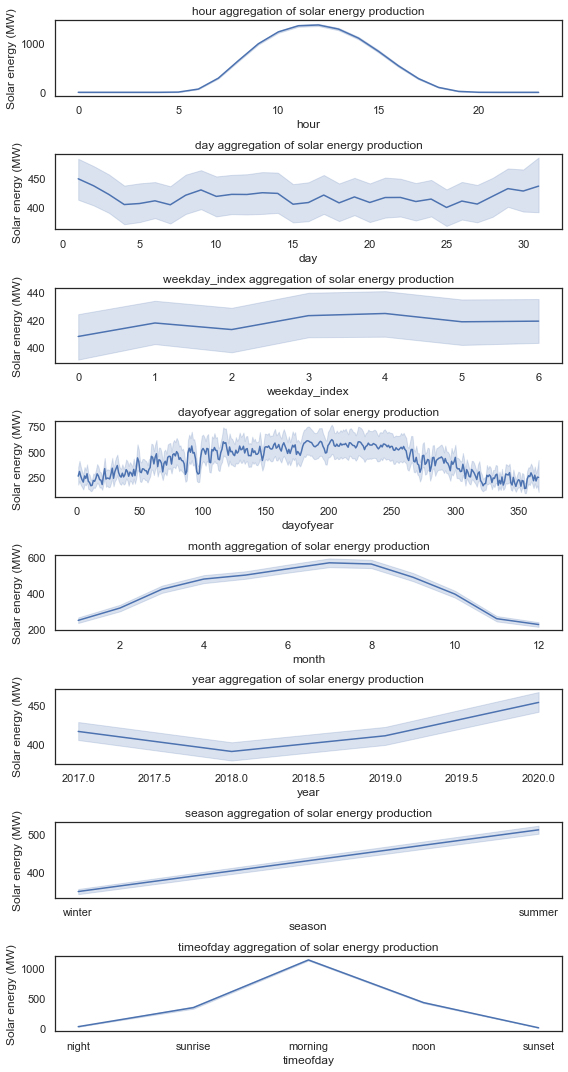

In [12]:
fig, ax = plt.subplots(len(temporal_features), 1, figsize = (8, 15))
for i,feature in enumerate(temporal_features):
   _ = sns.lineplot(x=feature, 
                    y='Solar energy (MW)', 
                    data=agg_solar_energy_df,
                    ax=ax[i]).set_title('%s aggregation of solar energy production' % feature)
plt.tight_layout()

Exploring the temporal patterns of wind energy production it becomes obvious that there are no seasonal patterns and this is evidence of the intermittent nature of wind elements. In addition, there is a trend of increasing wind energy production thoughout the years and a decrease from winter to summer.

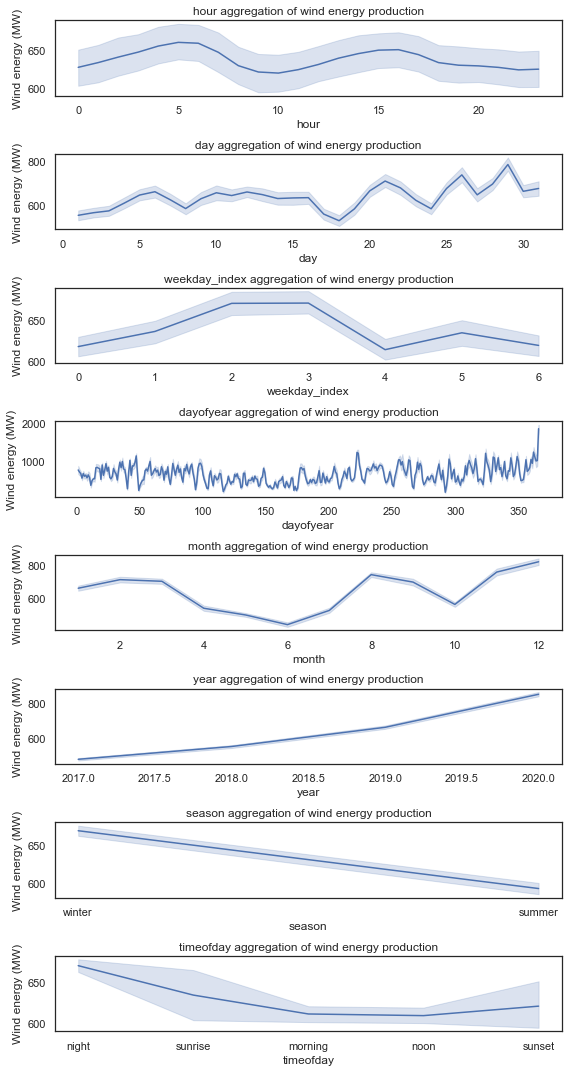

In [13]:
fig, ax = plt.subplots(len(temporal_features), 1, figsize = (8, 15))
for i,feature in enumerate(temporal_features):
   _ = sns.lineplot(x=feature, 
                    y='Wind energy (MW)', 
                    data=agg_wind_energy_df,
                    ax=ax[i]).set_title('%s aggregation of wind energy production' % feature)
plt.tight_layout()

,airTemperature,cloudCover,gust,humidity,precipitation,pressure,visibility,windDirection,windSpeed,Solar energy (MW),hour,month,year,day,dayofyear,weekday_index,season,timeofday
time,,,,,,,,,,,,,,,,,,
2020-12-31 19:00:00+01:00,9.114444,22.117778,7.974444,85.508889,0.0,1014.367778,24.13,256.385556,2.586667,0.0,19,12,2020,31,366,3,winter,night
2020-12-31 20:00:00+01:00,8.858889,8.531111,8.136667,82.986667,0.0,1014.736667,24.13,260.053333,2.441111,0.0,20,12,2020,31,366,3,winter,night
2020-12-31 21:00:00+01:00,8.577778,3.935556,7.850000,81.464444,0.0,1015.200000,24.14,263.715556,2.303333,0.0,21,12,2020,31,366,3,winter,night
2020-12-31 22:00:00+01:00,8.315556,2.017778,7.344444,79.937778,0.0,1015.472222,24.14,267.383333,2.157778,0.0,22,12,2020,31,366,3,winter,night
2020-12-31 23:00:00+01:00,8.035556,3.044444,6.901111,75.550000,0.0,1015.524444,24.14,273.384444,2.074444,0.0,23,12,2020,31,366,3,winter,night


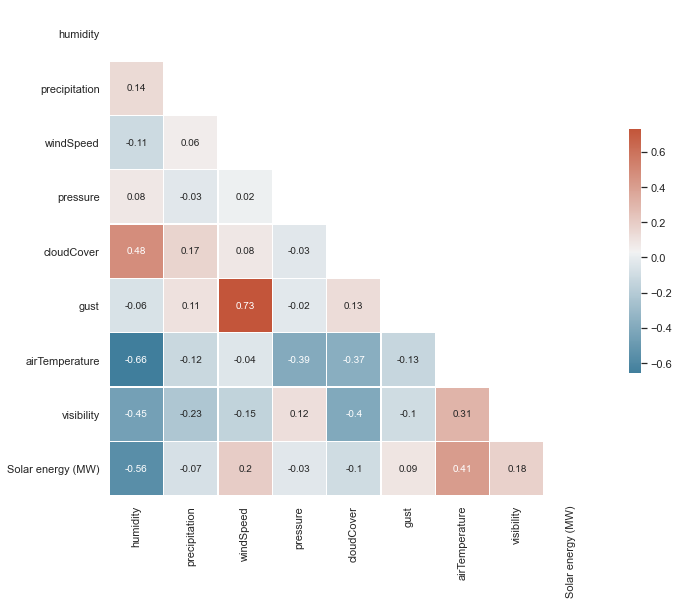

In [14]:
data_eval.plot_corr_heatmap(agg_solar_energy_df, weather_features + ['Solar energy (MW)'])
agg_solar_energy_df.tail()

,airTemperature,cloudCover,gust,humidity,precipitation,pressure,visibility,windDirection,windSpeed,Wind energy (MW),hour,month,year,day,dayofyear,weekday_index,season,timeofday
time,,,,,,,,,,,,,,,,,,
2020-12-31 19:00:00+01:00,9.767963,21.890000,5.894444,80.138889,0.015926,1013.255926,24.030000,246.156111,3.573333,1659.0,19,12,2020,31,366,3,winter,night
2020-12-31 20:00:00+01:00,9.420185,24.256111,5.824815,81.385370,0.011852,1013.739074,24.044444,245.211481,3.403889,1516.0,20,12,2020,31,366,3,winter,night
2020-12-31 21:00:00+01:00,9.178704,24.375000,5.558704,81.463148,0.025185,1014.223519,24.065556,244.266111,3.236296,1426.0,21,12,2020,31,366,3,winter,night
2020-12-31 22:00:00+01:00,8.955926,26.747407,5.263333,80.820000,0.033333,1014.607222,24.081667,243.321481,3.066852,1382.0,22,12,2020,31,366,3,winter,night
2020-12-31 23:00:00+01:00,8.728889,29.917963,5.002593,80.800556,0.022963,1014.706481,23.686111,243.764074,2.862963,1416.0,23,12,2020,31,366,3,winter,night


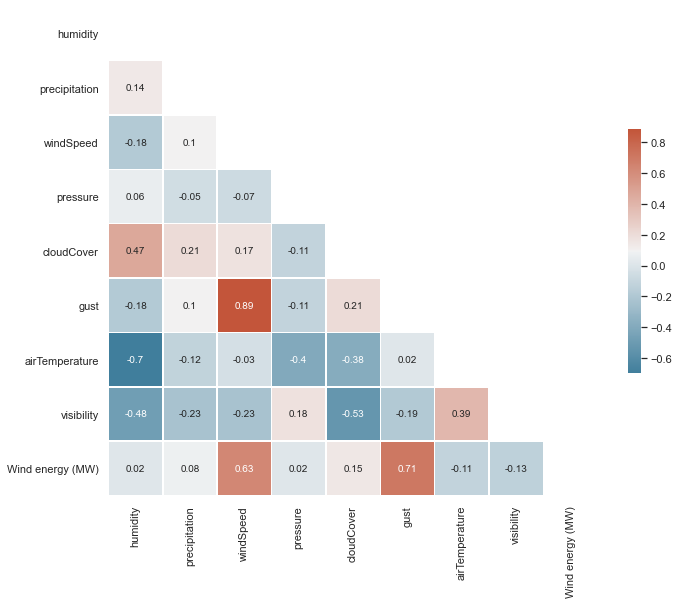

In [15]:
data_eval.plot_corr_heatmap(agg_wind_energy_df, weather_features + ['Wind energy (MW)'])
agg_wind_energy_df.tail()

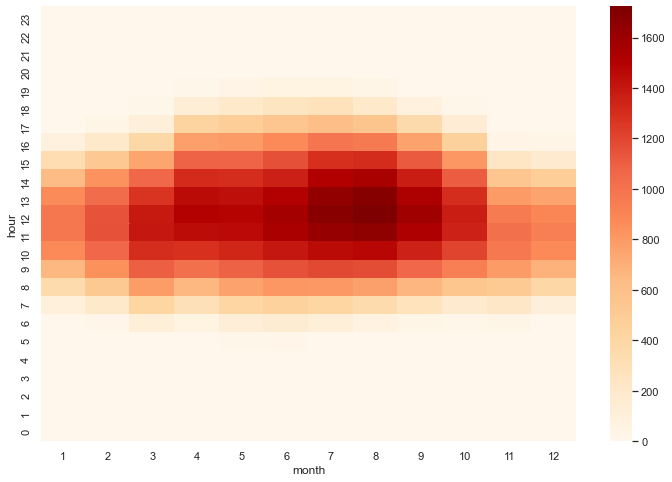

In [16]:
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(agg_solar_energy_df.pivot_table(values='Solar energy (MW)',
                                                 index='hour', 
                                                 columns = 'month', 
                                                 aggfunc = 'mean').sort_index(ascending = False),
                 cmap='OrRd')

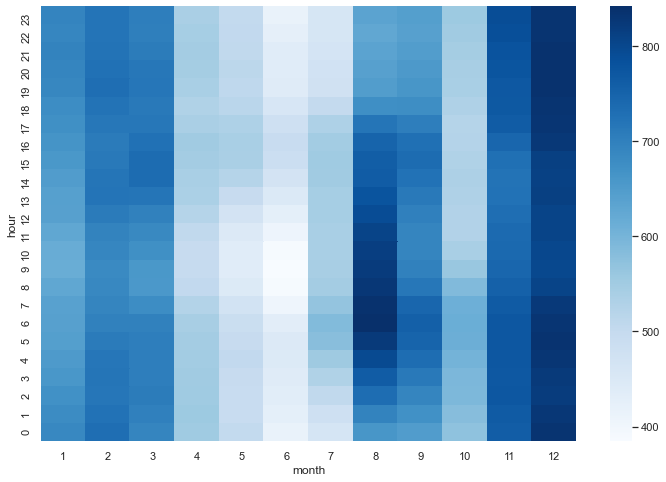

In [17]:
# sns.set(font_scale = 2.5)
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(agg_wind_energy_df.pivot_table(values='Wind energy (MW)',
                                                 index='hour', 
                                                 columns = 'month', 
                                                 aggfunc = 'mean').sort_index(ascending = False),
                 cmap='Blues')

#### 1.2.1 Cyclical (polar) features
Temporal features are in fact cyclical in their nature so instead of applying them as one hot encoding we attemp a representation with polar cordinates. For each feature we represent its value $x$ as:
$$x_{sin} = \sin(\frac{2*\pi*x}{\max(x)}) $$
$$x_{cos} = \cos(\frac{2*\pi*x}{\max(x)}) $$

In [18]:
for col in cyclical_features:
   # solar 
   agg_solar_energy_df['sin_%s' % col] = agg_solar_energy_df[col].apply(lambda x: np.sin((2 * np.pi * x)/agg_solar_energy_df[col].max()))
   agg_solar_energy_df['cos_%s' % col] = agg_solar_energy_df[col].apply(lambda x: np.cos((2 * np.pi * x)/agg_solar_energy_df[col].max()))
   # wind 
   agg_wind_energy_df['sin_%s' % col] = agg_wind_energy_df[col].apply(lambda x: np.sin((2 * np.pi * x)/agg_wind_energy_df[col].max()))
   agg_wind_energy_df['cos_%s' % col] = agg_wind_energy_df[col].apply(lambda x: np.cos((2 * np.pi * x)/agg_wind_energy_df[col].max()))
   

#### 1.2.2 One-hot-encoded features
One-hot-encoding is chosen for some of the features such as **season** and **year**

In [19]:
for col in one_hot_features:
   agg_solar_energy_df[col] = agg_solar_energy_df[col].astype('category')
   agg_wind_energy_df[col] = agg_wind_energy_df[col].astype('category')
   
# Preparing dummy columns
agg_wind_energy_df = pd.get_dummies(agg_wind_energy_df)
agg_solar_energy_df = pd.get_dummies(agg_solar_energy_df)

#### 1.2.3 Last day's production as feature
We add the energy production of the previous week as a feature. Along with weather variables according to the correlation exhibited below

Calculate past week features:
    * hourly energy generation of past week
    * hourly weather variables of past week
    * rolling statistics of energy generation for t-24h to t-72h for every 3 hours

In [20]:
# Get weather features from the past 3 days 
for h in range(1, 72, 2):
   agg_solar_energy_df['t-%sh temp' % h] = agg_solar_energy_df['airTemperature'].shift(freq=timedelta(hours=h))
   agg_solar_energy_df['t-%sh humidity' % h] = agg_solar_energy_df['humidity'].shift(freq=timedelta(hours=h))
    
   agg_wind_energy_df['t-%sh wind' % h] = agg_wind_energy_df['windSpeed'].shift(freq=timedelta(hours=h))
   agg_wind_energy_df['t-%sh gust' % h] = agg_wind_energy_df['gust'].shift(freq=timedelta(hours=h))

In [21]:
# Get weather features a day ahead
for h in range(1, 24, 2):
   agg_solar_energy_df['t+%sh temp' % h] = agg_solar_energy_df['airTemperature'].shift(freq=timedelta(hours=-h))
   agg_solar_energy_df['t+%sh humidity' % h] = agg_solar_energy_df['humidity'].shift(freq=timedelta(hours=-h))
    
   agg_wind_energy_df['t+%sh wind' % h] = agg_wind_energy_df['windSpeed'].shift(freq=timedelta(hours=-h))
   agg_wind_energy_df['t+%sh gust' % h] = agg_wind_energy_df['gust'].shift(freq=timedelta(hours=-h))
   

In [22]:
# Get energy data from 2 days (48h) before the target day to 1 week  (168h)
for h in range(48, 168):
   agg_solar_energy_df['t-%sh energy' % h] = agg_solar_energy_df['Solar energy (MW)'].shift(freq=timedelta(hours=h))
   agg_wind_energy_df['t-%sh energy' % h] = agg_wind_energy_df['Wind energy (MW)'].shift(freq=timedelta(hours=h))


In [23]:
# Get energy statistics from 48-96 hours before the target day
for h in range(48, 96, 6):    
   agg_solar_energy_df.loc[:, 'rolling_max_energy_%sh_win' % h] = agg_solar_energy_df['Solar energy (MW)'].rolling(window='%sH' % h).max()
   agg_solar_energy_df.loc[:, 'rolling_min_energy_%sh_win' % h] = agg_solar_energy_df['Solar energy (MW)'].rolling(window='%sH' % h).min()
   agg_solar_energy_df.loc[:, 'rolling_mean_energy_%sh_win' % h] = agg_solar_energy_df['Solar energy (MW)'].rolling(window='%sH' % h).mean()
   agg_solar_energy_df.loc[:, 'rolling_var_energy_%sh_win' % h] = agg_solar_energy_df['Solar energy (MW)'].rolling(window='%sH' % h).var()
   agg_solar_energy_df.loc[:, 'rolling_std_energy_%sh_win' % h] = agg_solar_energy_df['Solar energy (MW)'].rolling(window='%sH' % h).std()
   agg_solar_energy_df.loc[:, 'rolling_skew_energy_%sh_win' % h] = agg_solar_energy_df['Solar energy (MW)'].rolling(window='%sH' % h).skew()

   agg_wind_energy_df.loc[:, 'rolling_max_energy_%sh_win' % h] = agg_wind_energy_df['Wind energy (MW)'].rolling(window='%sH' % h).max()
   agg_wind_energy_df.loc[:, 'rolling_min_energy_%sh_win' % h] = agg_wind_energy_df['Wind energy (MW)'].rolling(window='%sH' % h).min()
   agg_wind_energy_df.loc[:, 'rolling_mean_energy_%sh_win' % h] = agg_wind_energy_df['Wind energy (MW)'].rolling(window='%sH' % h).mean()
   agg_wind_energy_df.loc[:, 'rolling_var_energy_%sh_win' % h] = agg_wind_energy_df['Wind energy (MW)'].rolling(window='%sH' % h).var()
   agg_wind_energy_df.loc[:, 'rolling_std_energy_%sh_win' % h] = agg_wind_energy_df['Wind energy (MW)'].rolling(window='%sH' % h).std()
   agg_wind_energy_df.loc[:, 'rolling_skew_energy_%sh_win' % h] = agg_wind_energy_df['Wind energy (MW)'].rolling(window='%sH' % h).skew()


In [24]:
# Get next week power output
for h in range(168):
   agg_solar_energy_df['t+%sh energy' % h] = agg_solar_energy_df['Solar energy (MW)'].shift(freq=timedelta(hours=-h))
   agg_wind_energy_df['t+%sh energy' % h] = agg_wind_energy_df['Wind energy (MW)'].shift(freq=timedelta(hours=-h))

agg_solar_energy_df.drop(columns='Solar energy (MW)', inplace=True)
agg_wind_energy_df.drop(columns='Wind energy (MW)', inplace=True)


#### Scale energy and weather features with MinMaxScaler and drop redundant features

In [25]:
# Drop excess rows
agg_solar_energy_df.dropna(inplace=True)
agg_wind_energy_df.dropna(inplace=True)

print('Data size before feature selection', agg_solar_energy_df.shape, agg_wind_energy_df.shape)

Data size before feature selection (34729, 469) (34729, 469)


#### Scaling data

In [26]:
selected_wind = weather_features + agg_wind_energy_df.filter(like='energy').columns.tolist()
selected_solar = weather_features + agg_solar_energy_df.filter(like='energy').columns.tolist()

# Scaling
agg_wind_energy_df.loc[:, selected_wind] = MinMaxScaler().fit_transform(agg_wind_energy_df[selected_wind].values)
agg_solar_energy_df.loc[:, selected_solar] = MinMaxScaler().fit_transform(agg_solar_energy_df[selected_solar].values)

# Drop extra features
agg_wind_energy_df.drop(columns=cyclical_features, inplace=True)
agg_solar_energy_df.drop(columns=cyclical_features, inplace=True)

**Selected features:**

In [27]:
print(agg_wind_energy_df.shape)
print(agg_solar_energy_df.shape)

(34729, 463)
(34729, 463)


## 2. Data split

We split the data for the different models that will be trained later:
   * Hour ahead split: hour ahead prediction model
   * Day ahead split: day ahed prediction
   * Week ahead split: week ahead prediction

### 2.1  1-step-ahead

Split the 4 year dataset in 3 years training and one year testing set. The years 2017-2019 will be used as train and the last year 2020 will be used for predictions.

In [33]:
def select_features(data_dest_dir, filename_train, filename_test, train_data, test_data, selection_model, target_variable):
   # Create export directory
   if not os.path.exists(data_dest_dir):      
      os.makedirs(data_dest_dir)

   start = datetime.now()
   print('Feature selection...')
   final_features = data_eval.final_feature_selection(model, 
                                                       train_data.drop(columns=target_variable), 
                                                       train_data.loc[:, target_variable])
   final_features += target_variable
   print('Finished feature selection in %s' % str(datetime.now()-start)) 
   print('Saving wind feature selection')
   train_data[final_features].to_csv(os.path.join(data_dest_dir, filename_train))   
   test_data[final_features].to_csv(os.path.join(data_dest_dir, filename_test))

   print('Data: \nFeatures: %s\ntrain: %s\ntest: %s\n' %    (train_data[final_features].columns,
                                                            train_data[final_features].shape, 
                                                            test_data[final_features].shape))
   return train_data[final_features], test_data[final_features]

From all past week features choose the rolling and lag features from 48h up to 96 hours ago

In [34]:
# Define target variable and ignore the other look ahead features
target_variable = agg_wind_energy_df.filter(regex='t\+.+ energy').columns.tolist()[:1]
all_target_variables = agg_wind_energy_df.filter(regex='t\+.+ energy').columns.tolist()
redundant_target_variables = [var for var in all_target_variables if var not in target_variable]
# filter out excess features
all_extra_features = agg_wind_energy_df.filter(regex='t\-|rolling').columns.tolist()
lag_weather = ['t-%sh %s' % (h,w) for h in range(24) for w in ['gust', 'wind']]
lag_energy = ['t-%sh energy' % h for h in range(48, 96)]
rolling_features = agg_wind_energy_df.filter(regex='rolling.+').columns.tolist()

redundant_variables = [var for var in all_extra_features if var not in lag_weather + lag_energy + rolling_features]


# Create export directory
data_dest_dir = os.path.join('resources', 'forecasting_data', '1-step-ahead')
if not os.path.exists(data_dest_dir):      
    os.makedirs(data_dest_dir)

# Train split
train_data = agg_wind_energy_df.loc['2017':'2019'].copy()
train_data.drop(columns=redundant_target_variables + redundant_variables, inplace=True)
# Test split
test_data = agg_wind_energy_df.loc['2020'].copy()
test_data.drop(columns=redundant_target_variables + redundant_variables, inplace=True)

model = Ridge(normalize = True, tol=1e-5)     
# model = xgb.XGBRegressor()

train_data, test_data = select_features(data_dest_dir, 
                                     'wind_train_hour.csv', 
                                     'wind_test_hour.csv', 
                                     train_data, 
                                     test_data,
                                     model, 
                                     target_variable)


###################################3

## Solar dataset
# Define target variable and ignore the other look ahead features
target_variable = agg_solar_energy_df.filter(regex='t\+.+ energy').columns.tolist()[:1]
all_target_variables = agg_solar_energy_df.filter(regex='t\+.+ energy').columns.tolist()
redundant_target_variables = [var for var in all_target_variables if var not in target_variable]
# filter out excess features
all_extra_features = agg_solar_energy_df.filter(regex='t\-|rolling').columns.tolist()
lag_weather = ['t-%sh %s' % (h,w) for h in range(24) for w in ['temp', 'humidity']]
lag_energy = ['t-%sh energy' % h for h in range(48, 96)]
rolling_features = agg_solar_energy_df.filter(regex='rolling.+').columns.tolist()

redundant_variables = [var for var in all_extra_features if var not in lag_weather + lag_energy + rolling_features]

# Train split
train_data = agg_solar_energy_df.loc['2017':'2019'].copy()
train_data.drop(columns=redundant_target_variables + redundant_variables, inplace=True)

# Test split
test_data = agg_solar_energy_df.loc['2020'].copy()
test_data.drop(columns=redundant_target_variables + redundant_variables, inplace=True)

model = Ridge(normalize = True, tol=1e-5)     
# model = xgb.XGBRegressor()
train_data, test_data = select_features(data_dest_dir, 
                                        'solar_train_hour.csv', 
                                        'solar_test_hour.csv', 
                                        train_data, 
                                        test_data,
                                        model, 
                                        target_variable)


Feature selection...
Finished feature selection in 0:00:25.028088
Saving wind feature selection
Data: 
Features: Index(['airTemperature', 'cloudCover', 'gust', 'humidity', 'precipitation',
       'pressure', 'visibility', 'windSpeed', 'sin_windDirection',
       'cos_windDirection',
       ...
       'rolling_var_energy_84h_win', 'rolling_std_energy_84h_win',
       'rolling_skew_energy_84h_win', 'rolling_max_energy_90h_win',
       'rolling_min_energy_90h_win', 'rolling_mean_energy_90h_win',
       'rolling_var_energy_90h_win', 'rolling_std_energy_90h_win',
       'rolling_skew_energy_90h_win', 't+0h energy'],
      dtype='object', length=168)
train: (26112, 168)
test: (8617, 168)

Feature selection...
Finished feature selection in 0:00:23.179036
Saving wind feature selection
Data: 
Features: Index(['airTemperature', 'cloudCover', 'gust', 'humidity', 'precipitation',
       'pressure', 'visibility', 'windSpeed', 'sin_windDirection',
       'cos_windDirection',
       ...
       'rolli